In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d


(36, 2)


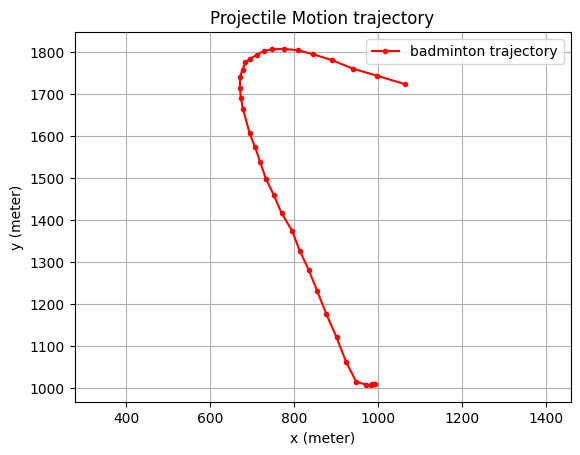

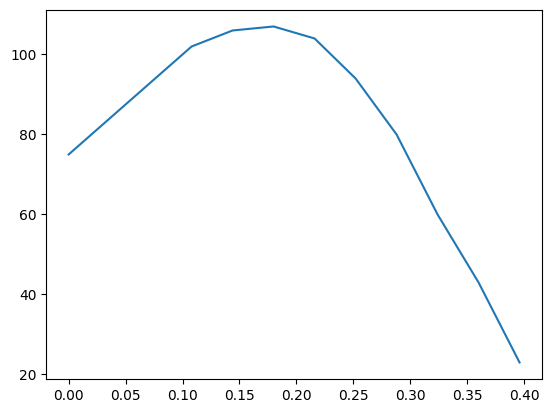

In [139]:
badminton_trajectory = np.load("badminton_trajectory.npy")
print(badminton_trajectory.shape)

#FPS = 30 so each frame = 1/30 s
#badminton_trajectory.shape = 36
#video shape = (1080, 1920)

x_with_resistance = badminton_trajectory[:, 0]
y_with_resistance = badminton_trajectory[:, 1]
x_trajectory = x_with_resistance
y_trajectory = []
for i in range(len(y_with_resistance)):
    y_trajectory.append(1920 - 1 - y_with_resistance[i])

ts = np.linspace(0, 0.033*36, 36)

# 绘制轨迹
plt.plot(x_trajectory, y_trajectory, label = 'badminton trajectory', marker='o', markersize = 3, c = 'r')
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

#using interpolation method to generate more data point
x_trajectory_half = x_trajectory[:12]
y_trajectory_half = y_trajectory[:12]

t_train = np.linspace(0, 0.033*12, 12)
y_train = np.array(y_trajectory_half[::-1])
y_train = y_train.copy() - 1700

plt.plot(t_train, y_train)
plt.show()

In [140]:
class trainable_Euler_method(nn.Module):
    # define a simple neural network
    def __init__(self, hidden_dim = 128):
        
        super(trainable_Euler_method, self).__init__()
        
        self.NN = nn.Sequential(
                                nn.Linear(1, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, 1),                          
                                )
        
        
    def forward(self,x0, v0, nt, dt):
        
        x_pred = torch.zeros(nt,)
        x_pred[0] = x0
        x_k = x0
        v_k = v0
        for i in range(1,nt):

            x_k_1_pred = x_k + dt*v_k # Euler method
            v_k = self.NN(v_k)

            x_pred[i] = x_k_1_pred

            x_k = x_k_1_pred

            
        return x_pred

In [141]:
m = 12
t_m = torch.linspace(0, 0.033*12,m)
nt = len(t_m)
x_m =  torch.from_numpy(y_train).type(torch.float32)
print(x_m)
dt = t_m[1] - t_m[0]
print(dt)

tensor([ 75.,  84.,  93., 102., 106., 107., 104.,  94.,  80.,  60.,  43.,  23.])
tensor(0.0360)


epoch: 0, loss_train: 652.4202
epoch: 100, loss_train: 334.4202
epoch: 200, loss_train: 161.5395
epoch: 300, loss_train: 152.7175
epoch: 400, loss_train: 145.5273
epoch: 500, loss_train: 131.6046
epoch: 600, loss_train: 118.2783
epoch: 700, loss_train: 103.8327
epoch: 800, loss_train: 90.9251
epoch: 900, loss_train: 80.0666
epoch: 1000, loss_train: 71.3750
epoch: 1100, loss_train: 64.9655
epoch: 1200, loss_train: 57.9253
epoch: 1300, loss_train: 53.4883
epoch: 1400, loss_train: 46.5580
epoch: 1500, loss_train: 41.0383
epoch: 1600, loss_train: 36.1450
epoch: 1700, loss_train: 31.7922
epoch: 1800, loss_train: 27.9207
epoch: 1900, loss_train: 24.5051
epoch: 2000, loss_train: 22.7056
epoch: 2100, loss_train: 46.8558
epoch: 2200, loss_train: 29.7001
epoch: 2300, loss_train: 26.3728
epoch: 2400, loss_train: 22.6434
epoch: 2500, loss_train: 19.5240
epoch: 2600, loss_train: 18.0672
epoch: 2700, loss_train: 16.7920
epoch: 2800, loss_train: 15.5769
epoch: 2900, loss_train: 14.4174
epoch: 3000, l

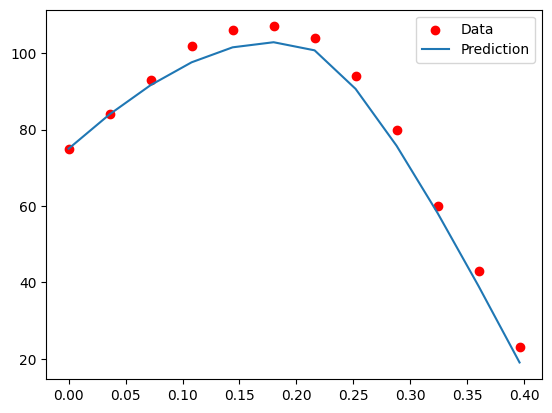

In [142]:
lr = 5e-3
num_epochs = 15000
global_step = 0
epoch_loss = 0

model = trainable_Euler_method()
params = model.parameters()
optimizer = optim.Adam(params, lr= lr)

#lr = 0.1
x0 = x_m[0:1]
v0 = ((x_m[1]-x_m[0])/dt).unsqueeze(0)


for epoch in range(num_epochs):
    
    global_step += 1            
    optimizer.zero_grad()
    
    x_pred = model(x0, v0, nt, dt)
    loss = torch.mean((x_pred - x_m)**2)   
    loss.backward()
    optimizer.step() 

    if not epoch % 100:
           
        print('epoch: {}, loss_train: {:.4f}'.format(epoch, loss)) 

plt.figure()
plt.scatter(t_m,x_m, color = "r", label = "Data")        
plt.plot(t_m, x_pred.detach().numpy(), label = "Prediction"  )   
plt.legend() 

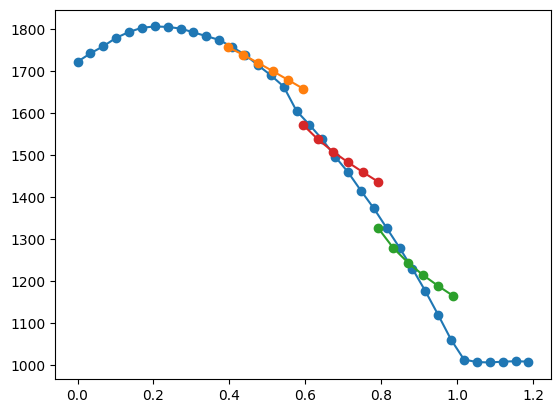

In [229]:
#test in second half
test_y = y_trajectory[12:24]

test_y0 = test_y[0]
test_v0 = ((test_y[1]-test_y[0])/dt).unsqueeze(0)
x_pred = model(test_y0, test_v0, 6, dt)

y3 = y_trajectory[24]
v3 = ((y_trajectory[25]-y_trajectory[24])/dt).unsqueeze(0)
y_pred3 = model(y3, v3, 6, dt)


y4 = y_trajectory[18]
v4 = ((y_trajectory[19]-y_trajectory[18])/dt).unsqueeze(0)
y_pred4 = model(y4, v4, 6, dt)

plt.plot(np.linspace(0,0.033*36,36), y_trajectory,marker='o')

plt.plot(np.linspace(0.033*12,0.033*18,6), x_pred.detach().numpy(),marker='o')
plt.plot(np.linspace(0.033*24,0.033*30,6), y_pred3.detach().numpy(),marker='o')
plt.plot(np.linspace(0.033*18,0.033*24,6), y_pred4.detach().numpy(),marker='o')
plt.show()

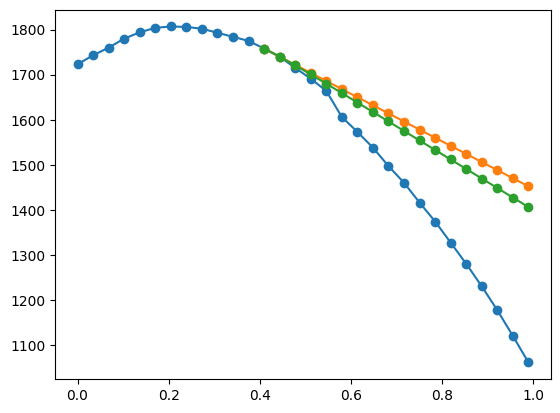

In [261]:

i = 12
y_true_pred = []
y_start = y_trajectory[i]

v_start = ((y_trajectory[i+1]-y_trajectory[i])/dt).unsqueeze(0)

while i < 30:
    y_pred = model(y_start, v_start, 6, dt)
    y_true_pred.append(y_pred.detach().numpy()[0])
    
    v_start = ((y_pred.detach().numpy()[1]-y_pred.detach().numpy()[0])/dt).unsqueeze(0)
    y_start = y_pred.detach().numpy()[1]
    y_start= torch.from_numpy(np.array(y_start, dtype=np.float32))


    i = i + 1
i=12
y_start = y_trajectory[i]
v_start = ((y_trajectory[i+1]-y_trajectory[i])/dt).unsqueeze(0)
all_pred = model(y_start, v_start, 18, dt)

t_total = np.linspace(0,0.033*30,30)
plt.plot(t_total, y_trajectory[:30],marker='o')
plt.plot(t_total[12:30], y_true_pred,marker='o')
plt.plot(t_total[12:30], all_pred.detach().numpy(),marker='o')

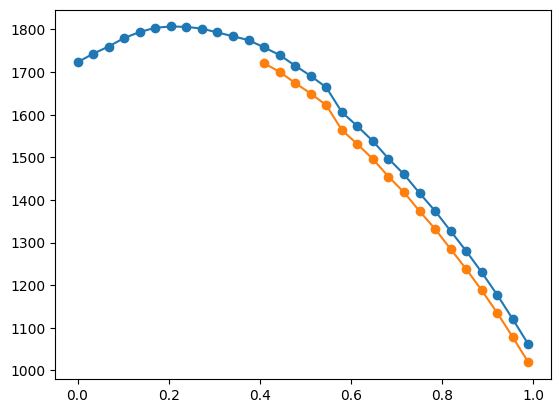

In [271]:
i = 12
y_true_pred = []
y_start = y_trajectory[i]

v_start = ((y_trajectory[i+1]-y_trajectory[i])/dt).unsqueeze(0)

while i < 30:
    y_pred = model(y_start, v_start, 6, dt)
    y_true_pred.append(y_pred.detach().numpy()[2])
    i = i + 1
    y_start = y_trajectory[i]
    v_start = ((y_pred.detach().numpy()[2] - y_pred.detach().numpy()[1])/dt).unsqueeze(0)

t_total = np.linspace(0,0.033*30,30)
plt.plot(t_total, y_trajectory[:30],marker='o')
plt.plot(t_total[12:30], y_true_pred,marker='o')